In [52]:
import pandas as pd
import numpy as np
from sklearn.covariance import EmpiricalCovariance
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge
import math
import scipy.optimize as opt

In [53]:
data = pd.read_csv("gp_data_1986_to_2015.csv")
data.head()

,Month,Mkt-RF,RF,Agric,Food,Soda,Beer,Smoke,Toys,Fun,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
0,198601,0.65,0.56,7.92,2.38,-1.20,-0.86,5.55,2.14,3.91,...,0.78,-1.11,0.85,3.80,4.61,1.91,5.60,2.48,1.67,-0.09
1,198602,7.13,0.53,13.98,7.89,11.68,7.71,12.20,10.72,8.28,...,7.47,2.71,8.34,9.98,8.68,10.61,7.03,8.85,7.21,9.27
2,198603,4.88,0.60,2.74,7.84,10.89,9.17,11.52,5.65,6.86,...,4.96,-0.11,0.04,-1.15,4.18,5.61,3.22,7.41,9.11,6.42
3,198604,-1.31,0.52,5.24,-0.57,4.44,-2.92,3.64,3.91,8.36,...,3.33,3.87,3.55,2.69,-2.50,-0.93,-2.64,1.70,-0.70,3.86
4,198605,4.62,0.49,1.08,8.55,7.95,6.37,10.16,3.16,5.91,...,5.41,1.01,-0.75,2.51,6.66,5.07,0.70,5.52,11.95,4.89


# Data Exploration and Analysis

## Pre-processing

In [54]:
excess_returns_43 = data.iloc[:, 3:]
for col in excess_returns_43.columns:
    excess_returns_43[col] -= data['RF']

excess_returns_43.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
0,7.36,1.82,-1.76,-1.42,4.99,1.58,3.35,-1.34,-1.52,4.66,...,0.22,-1.67,0.29,3.24,4.05,1.35,5.04,1.92,1.11,-0.65
1,13.45,7.36,11.15,7.18,11.67,10.19,7.75,14.14,10.20,8.80,...,6.94,2.18,7.81,9.45,8.15,10.08,6.50,8.32,6.68,8.74
2,2.14,7.24,10.29,8.57,10.92,5.05,6.26,4.47,4.97,5.57,...,4.36,-0.71,-0.56,-1.75,3.58,5.01,2.62,6.81,8.51,5.82
3,4.72,-1.09,3.92,-3.44,3.12,3.39,7.84,-1.66,-2.18,-3.30,...,2.81,3.35,3.03,2.17,-3.02,-1.45,-3.16,1.18,-1.22,3.34
4,0.59,8.06,7.46,5.88,9.67,2.67,5.42,10.47,4.12,9.29,...,4.92,0.52,-1.24,2.02,6.17,4.58,0.21,5.03,11.46,4.40


## Basic Portfolio Construction and In-Sample Analysis

In [55]:
ewp_w = [1 / 43 for i in range(43)]

def estimate_V(data):
    Vhat = EmpiricalCovariance().fit(data).covariance_
    return Vhat

def estimate_mu (data):  
    mu_hat = EmpiricalCovariance().fit(data).location_
    
    return mu_hat

V = estimate_V(excess_returns_43)
mu = estimate_mu(excess_returns_43)

def gmv(V):
    n = len(V)
    w_g = np.linalg.inv(V) @ np.ones(n)
    w_g /= np.sum(w_g)
    
    return w_g

gmv_w = gmv(V)

def tangency(mu, V):   
    w_t = np.linalg.inv(V) @ mu
    w_t /= np.sum(w_t)

    return w_t

tangency_w = tangency(mu, V)

# print("EWP:")
# print(ewp_w)
# print("GMV:")
# print(gmv_w)
# print("tangency")
# print(tangency_w)

In [56]:
plus_market = excess_returns_43.copy()
plus_market['Market'] = data.iloc[:, 1]

betas = []

V_market = estimate_V(plus_market)

last = len(V_market) - 1
for i in range(len(V_market) - 1):
    betas.append(V_market[i, last] / V_market[last, last])
    
betas = np.array(betas)

In [57]:
def evaluate_portfolio_performance(w, mu, V, rf = 0):
    return {'Er': mu.T @ w, 'sigma': np.sqrt(w.T @ V @ w), 
            'beta': np.dot(betas, w), 'Sharpe': (mu.T @ w - rf)/(np.sqrt(w.T @ V @ w)) }

In [58]:
er_ls = []
std_ls = []
beta_ls = []
sharpe_ls = []

for w in [(ewp_w, "EWP"), (gmv_w, "GMV"), (tangency_w, "Tangency")]:
    temp = evaluate_portfolio_performance(np.array(w[0]), mu, V)
    er_ls.append(temp['Er'])
    std_ls.append(temp['sigma'])
    beta_ls.append(temp['beta'])
    sharpe_ls.append(temp['Sharpe'])
    print(f"{w[1]:}")
    print(temp)

er_ls.append(np.mean(data.iloc[:, 1]))
std_ls.append(np.std(data.iloc[:, 1]))
beta_ls.append(1)
sharpe_ls.append(er_ls[-1] / std_ls[-1])
print("Market:")
print({"Er": er_ls[-1], "sigma": std_ls[-1], 'beta': beta_ls[-1], 'Sharpe': sharpe_ls[-1]})

EWP
{'Er': 0.7183475452196382, 'sigma': 4.650387373832146, 'beta': 0.9832954985774046, 'Sharpe': 0.15447047470965516}
GMV
{'Er': 0.5621418294818589, 'sigma': 2.860150994022063, 'beta': 0.4001535014493476, 'Sharpe': 0.19654271073687327}
Tangency
{'Er': 1.9168376228449373, 'sigma': 5.281516881105629, 'beta': 0.5260352954725876, 'Sharpe': 0.3629331621948102}
Market:
{'Er': 0.6363611111111116, 'sigma': 4.478294111308071, 'beta': 1, 'Sharpe': 0.1420989991488603}


In [59]:
summarised_table = pd.DataFrame({
    "Expected Return": er_ls,
    "Standard Deviation": std_ls,
    "Sharpe ratio": sharpe_ls,
})
summarised_table = summarised_table.transpose()
summarised_table.columns = pd.Series(["EWP", "GMV", "Tangency", "Market"])
summarised_table

,EWP,GMV,Tangency,Market
Expected Return,0.718348,0.562142,1.916838,0.636361
Standard Deviation,4.650387,2.860151,5.281517,4.478294
Sharpe ratio,0.154470,0.196543,0.362933,0.142099


In [60]:
indiv_portfolio = pd.DataFrame()
indiv_portfolio['Standard Deviation'] = excess_returns_43.std()
indiv_portfolio['Expected Return'] = excess_returns_43.mean()

In [61]:
def evaluate_portfolio_performance_on_data(w, data_evaluate):
    V = estimate_V (data_evaluate)
    mu = estimate_mu (data_evaluate)
    
    return {'Er': mu.T @ w, 'sigma': np.sqrt(w.T @ V @ w), 
            'var': w.T @ V @ w, 'Sharpe': (mu.T @ w - 0)/(np.sqrt(w.T @ V @ w)) }

In [62]:
def get_EF_on_data (w_t, w_g, data_evaluate):
    trange = np.arange(0,1.1,0.01)
    sigma_range = np.zeros_like (trange) * np.nan
    Er_range = np.zeros_like (trange) * np.nan

    for i in np.arange(len(trange)):
        w_mix = trange[i] * w_t + (1-trange[i]) * w_g
        sigma_range[i] = evaluate_portfolio_performance_on_data (w_mix, data_evaluate) ['sigma']
        Er_range[i] = evaluate_portfolio_performance_on_data (w_mix, data_evaluate) ['Er']
        
    return sigma_range, Er_range

In [63]:
rf = np.mean(data['RF'])
rm_e = np.mean(data['Mkt-RF'])

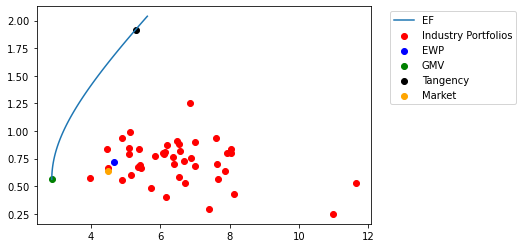

In [64]:
for i in range(len(indiv_portfolio)):
    temp = indiv_portfolio.iloc[i]
    plt.scatter(temp['Standard Deviation'], temp['Expected Return'],
                color = 'red', 
                label = 'Industry Portfolios' if i == 0 else '')

colors = ['blue', 'green', 'black', 'orange']
for i in range(len(summarised_table.columns)):
    col = summarised_table.columns[i]
    temp = summarised_table[col]
    plt.scatter(temp['Standard Deviation'], temp['Expected Return'],
                color = colors[i],
                label = col)
    
sigma_range, Er_range = get_EF_on_data(tangency_w, gmv_w, excess_returns_43)
plt.plot(sigma_range, Er_range, label = 'EF')

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

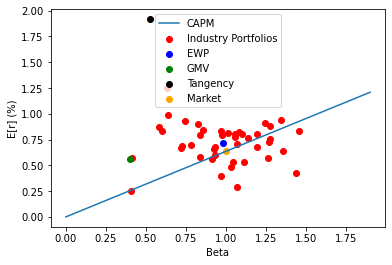

In [65]:
for i in range(len(indiv_portfolio)):
    temp = indiv_portfolio.iloc[i]
    plt.scatter(betas[i], temp['Expected Return'],
                color = 'red', 
                label = 'Industry Portfolios' if i == 0 else '')

colors = ['blue', 'green', 'black', 'orange']
for i in range(len(summarised_table.columns)):
    col = summarised_table.columns[i]
    temp = summarised_table[col]
    plt.scatter(beta_ls[i], temp['Expected Return'],
                color = colors[i],
                label = col)

xs = np.arange(0, 2, 0.1)
ys = [x * rm_e for x in xs]
plt.plot(xs, ys, label = 'CAPM')

plt.ylabel("E[r] (%)")
plt.xlabel("Beta")

plt.legend()
plt.show()

In [66]:
betas

array([0.78129415, 0.59990055, 0.82537766, 0.63929947, 0.63291577,
       1.04432918, 1.3442889 , 1.03052444, 0.71660342, 1.08233362,
       0.83713135, 0.85419291, 0.74590993, 1.05416082, 1.05439781,
       1.19290165, 1.1376044 , 1.19558499, 1.43734345, 1.07186699,
       1.26565653, 1.24125338, 1.2628331 , 1.01210611, 1.07099563,
       0.58203607, 0.4053946 , 1.09886229, 1.10958513, 0.7235385 ,
       0.41510252, 0.92880176, 0.96818748, 1.27171757, 1.35526866,
       1.45650257, 1.27582556, 0.92656973, 0.97795969, 0.93439698,
       0.91521112, 0.967557  , 0.83838302])

## Robust Portfolio Construction and Out-of-sample Analysis

In [67]:
train_data = data[data['Month'] < 201101]
test_data = data[data['Month'] >= 201101]

In [68]:
excess_returns_43_train = train_data.iloc[:, 3:]
for col in excess_returns_43_train.columns:
    excess_returns_43_train[col] -= train_data['RF']

excess_returns_43_train.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
0,7.36,1.82,-1.76,-1.42,4.99,1.58,3.35,-1.34,-1.52,4.66,...,0.22,-1.67,0.29,3.24,4.05,1.35,5.04,1.92,1.11,-0.65
1,13.45,7.36,11.15,7.18,11.67,10.19,7.75,14.14,10.20,8.80,...,6.94,2.18,7.81,9.45,8.15,10.08,6.50,8.32,6.68,8.74
2,2.14,7.24,10.29,8.57,10.92,5.05,6.26,4.47,4.97,5.57,...,4.36,-0.71,-0.56,-1.75,3.58,5.01,2.62,6.81,8.51,5.82
3,4.72,-1.09,3.92,-3.44,3.12,3.39,7.84,-1.66,-2.18,-3.30,...,2.81,3.35,3.03,2.17,-3.02,-1.45,-3.16,1.18,-1.22,3.34
4,0.59,8.06,7.46,5.88,9.67,2.67,5.42,10.47,4.12,9.29,...,4.92,0.52,-1.24,2.02,6.17,4.58,0.21,5.03,11.46,4.40


In [69]:
test_data_preprocessed = test_data.iloc[:, 3:]
for col in test_data_preprocessed.columns:
    test_data_preprocessed[col] -= test_data['RF']

test_data_preprocessed.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
300,5.00,-1.93,1.85,-3.63,-3.30,-6.73,3.58,2.79,-1.01,-3.33,...,2.55,3.78,6.48,3.97,2.93,3.66,-0.49,2.79,-1.29,-2.40
301,-1.21,6.74,3.19,0.59,8.64,6.17,1.23,2.55,1.65,8.87,...,2.12,1.62,4.02,4.80,3.16,4.26,1.41,2.96,1.37,3.91
302,0.32,1.63,4.57,3.34,6.32,1.58,-1.04,-0.22,0.22,-4.41,...,-0.05,-2.85,-3.25,1.67,1.83,0.43,3.00,1.46,0.47,1.84
303,-4.16,5.70,5.20,3.90,5.39,4.44,6.42,-0.03,4.93,8.00,...,2.66,2.03,4.74,3.64,1.96,0.67,2.93,4.06,5.20,1.40
304,2.86,2.14,3.66,0.49,4.50,-0.79,-0.51,1.07,3.05,0.34,...,-2.25,-1.74,-0.75,0.20,-0.65,5.71,-0.44,1.20,0.21,4.17


In [70]:
plus_market_train = excess_returns_43_train.copy()
plus_market_train['Market'] = train_data.iloc[:, 1]

betas_train = []

V_market_train = estimate_V(plus_market_train)

last = len(V_market) - 1
for i in range(len(V_market) - 1):
    betas_train.append(V_market_train[i, last] / V_market_train[last, last])
    
betas_train = np.array(betas_train)
betas_train_avg = np.mean(betas_train)

betas_train_est = 0.5 * betas_train + 0.5 * betas_train_avg

In [71]:
rf = np.mean(train_data['RF'])
rm_e = np.mean(train_data['Mkt-RF'])

In [72]:
capm_returns_e = [x * rm_e for x in betas_train_est]

In [73]:
coefs = np.zeros((43, 43))

for i in range(len(excess_returns_43_train.columns)):
    for j in range(i + 1, len(excess_returns_43_train.columns)):
        coef = np.corrcoef(excess_returns_43_train.iloc[:, i], excess_returns_43_train.iloc[:, j])[0, 1]
        coefs[i, j] = coef

avg_coefs = np.sum(coefs) / (43 * 42 / 2)

In [74]:
V_CC = np.zeros((43, 43))

for i in range(len(excess_returns_43_train.columns)):
    for j in range(len(excess_returns_43_train.columns)):
        std_1 = np.std(excess_returns_43_train.iloc[:, i])
        std_2 = np.std(excess_returns_43_train.iloc[:, j])
        V_CC[i, j] = std_1 * std_2 * avg_coefs if i != j else std_1 * std_2

V_normal = estimate_V(excess_returns_43_train)

V_train = 0.3 * V_CC + 0.7 * V_normal

In [75]:
tan_robust_w = tangency(capm_returns_e, V_train)
gmv_robust_w = gmv(V_train)

In [76]:
def evaluate_portfolio_performance_on_data(w, data_evaluate):    
    V = estimate_V (data_evaluate)
    mu = estimate_mu (data_evaluate)
    
    return {'Er': mu.T @ w, 'sigma': np.sqrt(w.T @ V @ w), 
            'Sharpe': (mu.T @ w - 0)/(np.sqrt(w.T @ V @ w)) }

In [77]:
V_normal = estimate_V(excess_returns_43_train)
mu_normal = estimate_mu(excess_returns_43_train)

gmv_w_in = gmv(V_normal)
tangency_w_in = tangency(mu_normal, V_normal)
ewp_w_in = ewp_w

In [78]:
# In sample
stds = []
ers = []
sharpes = []

for w in [ewp_w_in, gmv_w_in, tangency_w_in, gmv_robust_w, tan_robust_w]:
    temp = evaluate_portfolio_performance_on_data(np.array(w), excess_returns_43_train)
    stds.append(temp['sigma'])
    ers.append(temp['Er'])
    sharpes.append(temp['Sharpe'])

ers.append(np.mean(train_data.iloc[:, 1]))
stds.append(np.std(train_data.iloc[:, 1]))
sharpes.append(ers[-1] / stds[-1])

summarised_table = pd.DataFrame({
    "Expected Return": ers,
    "Standard Deviation": stds,
    "Sharpe ratio": sharpes,
})
summarised_table = summarised_table.transpose()
summarised_table.columns = pd.Series(["EWP", "GMV", "Tangency", "GMV Robust", "Tangency Robust", "Market"])
summarised_table

,EWP,GMV,Tangency,GMV Robust,Tangency Robust,Market
Expected Return,0.697483,0.467903,2.100185,0.486128,0.539942,0.561467
Standard Deviation,4.792854,2.880749,6.103180,3.050177,3.406652,4.649736
Sharpe ratio,0.145526,0.162424,0.344113,0.159377,0.158496,0.120752


In [79]:
# Out of sample
stds = []
ers = []
sharpes = []

for w in [ewp_w_in, gmv_w_in, tangency_w_in, gmv_robust_w, tan_robust_w]:
    temp = evaluate_portfolio_performance_on_data(np.array(w), test_data_preprocessed)
    stds.append(temp['sigma'])
    ers.append(temp['Er'])
    sharpes.append(temp['Sharpe'])

ers.append(np.mean(test_data.iloc[:, 1]))
stds.append(np.std(test_data.iloc[:, 1]))
sharpes.append(ers[-1] / stds[-1])

summarised_table = pd.DataFrame({
    "Expected Return": ers,
    "Standard Deviation": stds,
    "Sharpe ratio": sharpes,
})
summarised_table = summarised_table.transpose()
summarised_table.columns = pd.Series(["EWP", "GMV", "Tangency", "GMV Robust", "Tangency Robust", "Market"])
summarised_table

,EWP,GMV,Tangency,GMV Robust,Tangency Robust,Market
Expected Return,0.822671,0.863082,1.055857,1.122783,1.141517,1.010833
Standard Deviation,3.858277,2.963800,4.201550,2.708489,2.712153,3.473068
Sharpe ratio,0.213222,0.291208,0.251302,0.414542,0.420890,0.291049


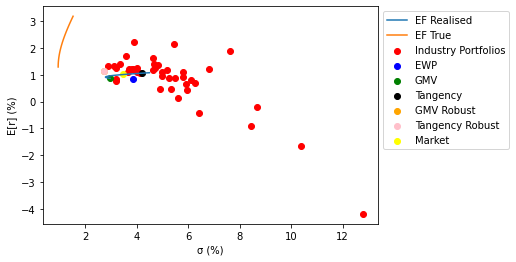

In [80]:
for i in range(43):
    data_subset = test_data_preprocessed.iloc[:, i]
    plt.scatter(np.std(data_subset), np.mean(data_subset),
                color = 'red', 
                label = 'Industry Portfolios' if i == 0 else '')

colors = ['blue', 'green', 'black', 'orange', 'pink', 'yellow']
for i in range(len(summarised_table.columns)):
    col = summarised_table.columns[i]
    temp = summarised_table[col]
    plt.scatter(temp['Standard Deviation'], temp['Expected Return'],
                color = colors[i],
                label = col)
    
sigma_range_realised, Er_range_realised = get_EF_on_data(tangency_w_in, gmv_w_in, test_data_preprocessed)
plt.plot(sigma_range_realised, Er_range_realised, label = 'EF Realised')

V_test = estimate_V(test_data_preprocessed)
mu_test = estimate_mu(test_data_preprocessed)

gmv_w_out = gmv(V_test)
tangency_w_out = tangency(mu_test, V_test)

sigma_range_true, Er_range_true = get_EF_on_data(tangency_w_out, gmv_w_out, test_data_preprocessed)
plt.plot(sigma_range_true, Er_range_true, label = 'EF True')

plt.ylabel("E[r] (%)")
plt.xlabel("σ (%)")

plt.legend(bbox_to_anchor=(1, 1), loc='best', ncol=1)

# Data Challenge

In [81]:
def get_betas(plus_market_train, shrink_constant = 0.5):
    betas_train = []

    V_market_train = estimate_V(plus_market_train)

    last = len(V_market) - 1
    for i in range(len(V_market) - 1):
        betas_train.append(V_market_train[i, last] / V_market_train[last, last])

    betas_train = np.array(betas_train)
    betas_train_avg = np.mean(betas_train)

    betas_train_est = shrink_constant * betas_train_avg +  (1 - shrink_constant) * betas_train
    return betas_train_est

In [82]:
V_dic = {
    "I": np.identity(43),
    "C": {},
    "D": {},
    "F": {}
}

def get_V_with_mode(data, V_mode, d_V):
    l = len(data)
    V_normal = estimate_V(data) if l not in V_dic["F"] else V_dic["F"][l]
    V_dic["F"][l] = V_normal
    if V_mode == "I":
        return d_V * V_dic["I"] + (1 - d_V) * V_normal
    elif V_mode == "D":
        if l not in V_dic["D"]:
            V = np.zeros((43, 43))

            for i in range(43):
                V[i, i] = np.std(data.iloc[:, i]) ** 2
            
            V_dic["D"][l] = V
        else:
            V = V_dic["D"][l]
            
        return d_V * V + (1 - d_V) * V_normal
    elif V_mode == "C":
        if l not in V_dic["C"]:
            coefs = np.zeros((43, 43))

            for i in range(len(excess_returns_43_train.columns)):
                for j in range(i + 1, len(excess_returns_43_train.columns)):
                    coef = np.corrcoef(excess_returns_43_train.iloc[:, i], excess_returns_43_train.iloc[:, j])[0, 1]
                    coefs[i, j] = coef

            avg_coefs = np.sum(coefs) / (43 * 42 / 2)

            V_CC = np.zeros((43, 43))

            for i in range(len(data.columns)):
                for j in range(len(data.columns)):
                    std_1 = np.std(data.iloc[:, i])
                    std_2 = np.std(data.iloc[:, j])
                    V_CC[i, j] = std_1 * std_2 * avg_coefs if i != j else std_1 * std_2
            V_dic["C"][l] = V_CC
        else:
            V_CC = V_dic["C"][l]

        return d_V * V_CC + (1 - d_V) * V_normal
    elif V_mode == "F":
        return V_normal
    else:
        print("Should not go here")

In [83]:
def get_E_with_mode(data, E_mode, d_E, betas):
    E_r = data.mean()
    rf = np.mean(train_data['RF'])
    rm_e = np.mean(train_data['Mkt-RF'])
    if E_mode == "E":
        avg = E_r.mean()
        temp = [avg] * 43
        return d_E * np.array(temp) + (1 - d_E) * E_r
    if E_mode == "S":
        stds = np.std(data)
        sharpes = E_r / stds
        mean_sharpes = sharpes.mean()
        same_sharpes = mean_sharpes * stds + rf
        
        return d_E * same_sharpes + (1 - d_E) * E_r
    if E_mode == "C":
        capm_e =  np.array([x * rm_e for x in betas])
        
        return d_E * capm_e + (1 - d_E) * E_r

In [84]:
def get_weights(port_mode, V_mode, E_mode, d_V, d_E, n_points, data, split_date = 201101, beta_shrink = 0.5, no_short = False):
    train_data = data[data['Month'] < split_date]
    train_data = train_data.iloc[-n_points:, :]
    test_data = data[data['Month'] >= split_date]
    test_data = test_data.iloc[:60, :]
    
    excess_returns_43_train = train_data.iloc[:, 3:]
    test_data_preprocessed = test_data.iloc[:, 3:]
    
    for new_data, rf_data in [(excess_returns_43_train, train_data['RF']), (test_data_preprocessed, test_data['RF'])]:
        for col in new_data.columns:
            new_data[col] -= rf_data
    
    plus_market_train = excess_returns_43_train.copy()
    plus_market_train['Market'] = train_data.iloc[:, 1]

    betas = get_betas(plus_market_train, shrink_constant = beta_shrink)
    
    V = get_V_with_mode(excess_returns_43_train, V_mode, d_V)
    E = get_E_with_mode(excess_returns_43_train, E_mode, d_E, betas)
    
    if not no_short:
        w = tangency(E, V) if port_mode == "Tangency" else gmv(V)
    else:
        init_weights = np.array([1 / 43] * 43)

        total_1_const = {
            'type': 'eq',
            'fun': lambda w: sum(w) - 1
        }

        bounds = [(0, None)] * 43
        
        if port_mode == "Tangency":
            res = opt.minimize(lambda w: -1 * (E.T @ w - 0)/(np.sqrt(w.T @ V @ E)), init_weights, 
                               bounds = bounds, constraints=[total_1_const])
        else:
            res = opt.minimize(lambda w: np.sqrt(w.T @ V @ w), init_weights, 
                               bounds = bounds, constraints=[total_1_const])
        w = res.x
        
    return w

In [85]:
def get_metrics(port_mode, V_mode, E_mode, d_V, d_E, n_points, data, split_date = 201101, beta_shrink = 0.5, no_short = False):
    """
    port_mode: "GMV" or "Tangency"
    V_mode: "I" (Identity), "D" (Diagonal), "C" (Constant), "F" (Full)
    E_mode: "E" (all returns equal), "S" (all Sharpe ratio equal), "C" (CAPM)
    d_V: weight of V with structural assumption (0-1)
    d_E: weight of E with structural assumption (0-1)
    n_points: number of data points for train (1-300)
    data: the full data
    """
    w = get_weights(port_mode, V_mode, E_mode, d_V, d_E, n_points, data, split_date, beta_shrink, no_short)
    
    dic = evaluate_portfolio_performance_on_data(w, test_data_preprocessed)
    
    return dic

In [86]:
def custom_plot(x, y, label, color, poly_fit = False, 
                poly_fit_deg = 0, title = None, x_label = None, 
                y_label = None, legend_outside = False,
                scatter_size = 20):
    xp = np.arange(min(x), max(x), 1)

    z = np.polyfit(x, y, poly_fit_deg)
    p = np.poly1d(z)
    pxp = p(xp)

    plt.scatter(x, y, color = color, label = label, s = scatter_size)
    
    if poly_fit:
        plt.plot(xp, pxp, color = color, label = f"Line of best fit: {label}")
    if title != None:
        plt.title(title)
    if x_label != None:
        plt.xlabel(x_label)
    if y_label != None:
        plt.ylabel(y_label)
    if legend_outside:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    else:
        plt.legend()

    return xp, pxp

## Choose how many data points to take
Old data might not be too relevant, while too few data points might mean that the model does not enough data points to learn enough information.

In [87]:
n_datas = np.arange(10, 300, 10)
ers_gmv = []
stds_gmv = []
sharpes_gmv = []

for n_data in n_datas:
    dic = get_metrics("GMV", "C", "C", 0.3, 1, n_data, data)
    ers_gmv.append(dic['Er'])
    stds_gmv.append(dic['sigma'])
    sharpes_gmv.append(dic['Sharpe'])

ers_tan = []
stds_tan = []
sharpes_tan = []
    
for n_data in n_datas:
    dic = get_metrics("Tangency", "C", "C", 0.3, 1, n_data, data)
    ers_tan.append(dic['Er'])
    stds_tan.append(dic['sigma'])
    sharpes_tan.append(dic['Sharpe'])

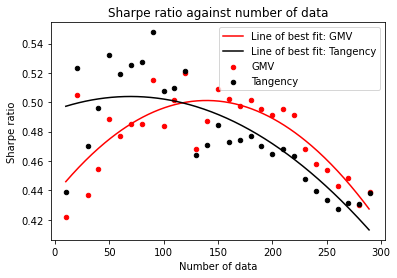

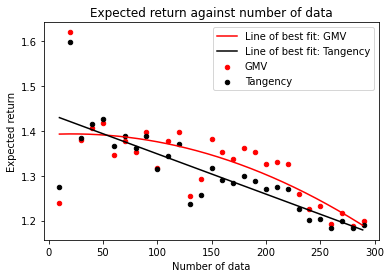

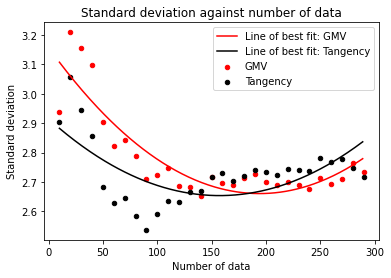

In [88]:
custom_plot(n_datas, sharpes_gmv, "GMV", "red", True, 2, 
                              "Sharpe ratio against number of data", "Number of data", "Sharpe ratio")
xp_tan, pxp_tan = custom_plot(n_datas, sharpes_tan, "Tangency", "black", True, 2)
m = max(pxp_tan)
i = np.where(pxp_tan == m)
max_sharpe_tan = xp_tan[i]
plt.show()

custom_plot(n_datas, ers_gmv, "GMV", "red", True, 2, "Expected return against number of data", 
            "Number of data", "Expected return")
custom_plot(n_datas, ers_tan, "Tangency", "black", True, 2)
plt.show()

xp_gmv, pxp_gmv = custom_plot(n_datas, stds_gmv, "GMV", "red", True, 2, 
                              "Standard deviation against number of data", "Number of data", "Standard deviation")
m = min(pxp_gmv)
i = np.where(pxp_gmv == m)
min_var_gmv = xp_gmv[i]
xp_tan, pxp_tan = custom_plot(n_datas, stds_tan, "Tangency", "black", True, 2)
m = min(pxp_tan)
i = np.where(pxp_tan == m)
min_var_tan = xp_tan[i]
plt.show()

In [89]:
n_points = math.ceil((min_var_tan + min_var_gmv) / 2)
n_points

176

## Sharpe Ratio, Return, and Standard Deviation against shrinkage constant for different structural assumptions on Correlation Matrix

In [90]:
d_Vs = np.arange(0, 1, 0.01)
ers_I_gmv = []
stds_I_gmv = []
sharpes_I_gmv = []
ers_I_tan = []
stds_I_tan = []
sharpes_I_tan = []

default_beta_shrink = 0.5

for d_V in d_Vs:
    dic = get_metrics("GMV", "I", "C", d_V, 1, n_points, data, beta_shrink = default_beta_shrink)
    ers_I_gmv.append(dic['Er'])
    stds_I_gmv.append(dic['sigma'])
    sharpes_I_gmv.append(dic['Sharpe'])
    dic = get_metrics("Tangency", "I", "C", d_V, 1, n_points, data, beta_shrink = default_beta_shrink)
    ers_I_tan.append(dic['Er'])
    stds_I_tan.append(dic['sigma'])
    sharpes_I_tan.append(dic['Sharpe'])

ers_D_gmv = []
stds_D_gmv = []
sharpes_D_gmv = []
ers_D_tan = []
stds_D_tan = []
sharpes_D_tan = []

for d_V in d_Vs:
    dic = get_metrics("GMV", "D", "C", d_V, 1, n_points, data, beta_shrink = default_beta_shrink)
    ers_D_gmv.append(dic['Er'])
    stds_D_gmv.append(dic['sigma'])
    sharpes_D_gmv.append(dic['Sharpe'])
    dic = get_metrics("Tangency", "D", "C", d_V, 1, n_points, data, beta_shrink = default_beta_shrink)
    ers_D_tan.append(dic['Er'])
    stds_D_tan.append(dic['sigma'])
    sharpes_D_tan.append(dic['Sharpe'])
    
ers_C_gmv = []
stds_C_gmv = []
sharpes_C_gmv = []
ers_C_tan = []
stds_C_tan = []
sharpes_C_tan = []

for d_V in d_Vs:
    dic = get_metrics("GMV", "C", "C", d_V, 1, n_points, data, beta_shrink = default_beta_shrink)
    ers_C_gmv.append(dic['Er'])
    stds_C_gmv.append(dic['sigma'])
    sharpes_C_gmv.append(dic['Sharpe'])
    dic = get_metrics("Tangency", "C", "C", d_V, 1, n_points, data, beta_shrink = default_beta_shrink)
    ers_C_tan.append(dic['Er'])
    stds_C_tan.append(dic['sigma'])
    sharpes_C_tan.append(dic['Sharpe'])

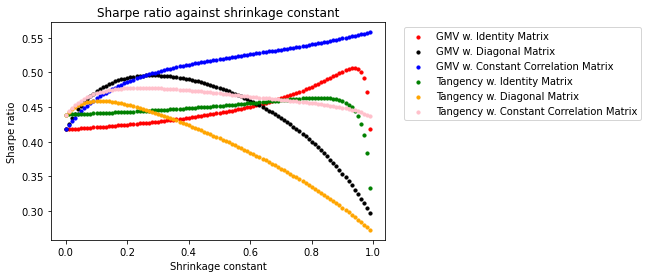

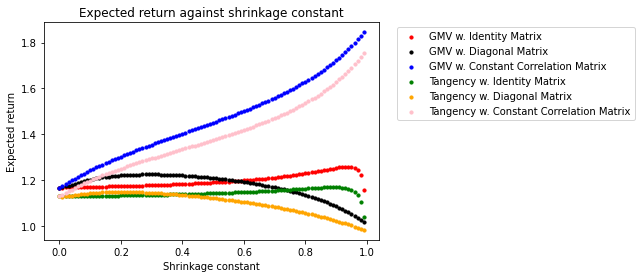

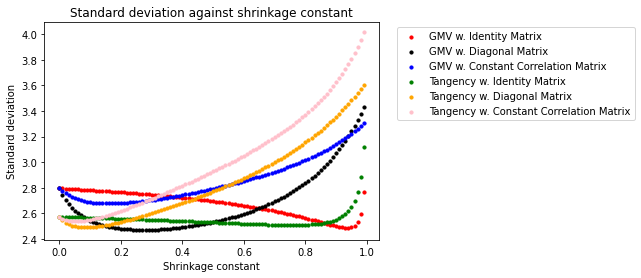

In [91]:
size = 10

custom_plot(d_Vs, sharpes_I_gmv, "GMV w. Identity Matrix", "red", False, 0, 
                          "Sharpe ratio against shrinkage constant", "Shrinkage constant", 
                          "Sharpe ratio", scatter_size = size)
custom_plot(d_Vs, sharpes_D_gmv, "GMV w. Diagonal Matrix", "black", scatter_size = size)
custom_plot(d_Vs, sharpes_C_gmv, "GMV w. Constant Correlation Matrix", "blue", scatter_size = size)
custom_plot(d_Vs, sharpes_I_tan, "Tangency w. Identity Matrix", "green", scatter_size = size)
custom_plot(d_Vs, sharpes_D_tan, "Tangency w. Diagonal Matrix", "orange", scatter_size = size)
custom_plot(d_Vs, sharpes_C_tan, "Tangency w. Constant Correlation Matrix", "pink", 
            legend_outside = True, scatter_size = size)
plt.show()

custom_plot(d_Vs, ers_I_gmv, "GMV w. Identity Matrix", "red", False, 0, 
            "Expected return against shrinkage constant", "Shrinkage constant", 
            "Expected return", scatter_size = size)
custom_plot(d_Vs, ers_D_gmv, "GMV w. Diagonal Matrix", "black", scatter_size = size)
custom_plot(d_Vs, ers_C_gmv, "GMV w. Constant Correlation Matrix", "blue", scatter_size = size)
custom_plot(d_Vs, ers_I_tan, "Tangency w. Identity Matrix", "green", scatter_size = size)
custom_plot(d_Vs, ers_D_tan, "Tangency w. Diagonal Matrix", "orange", scatter_size = size)
custom_plot(d_Vs, ers_C_tan, "Tangency w. Constant Correlation Matrix", "pink", 
            legend_outside = True, scatter_size = size)
plt.show()

custom_plot(d_Vs, stds_I_gmv, "GMV w. Identity Matrix", "red", False, 0, 
            "Standard deviation against shrinkage constant", "Shrinkage constant", 
            "Standard deviation", scatter_size = size)
custom_plot(d_Vs, stds_D_gmv, "GMV w. Diagonal Matrix", "black", scatter_size = size)
custom_plot(d_Vs, stds_C_gmv, "GMV w. Constant Correlation Matrix", "blue", scatter_size = size)
custom_plot(d_Vs, stds_I_tan, "Tangency w. Identity Matrix", "green", scatter_size = size)
custom_plot(d_Vs, stds_D_tan, "Tangency w. Diagonal Matrix", "orange", scatter_size = size)
custom_plot(d_Vs, stds_C_tan, "Tangency w. Constant Correlation Matrix", "pink", 
            legend_outside = True, scatter_size = size)
plt.show()

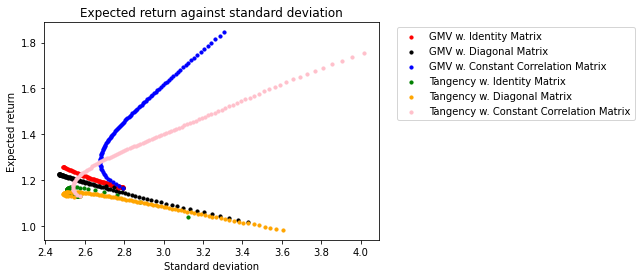

In [92]:
custom_plot(stds_I_gmv, ers_I_gmv, "GMV w. Identity Matrix", "red", False, 0, 
            "Expected return against standard deviation", "Standard deviation", 
            "Expected return", scatter_size = size)
custom_plot(stds_D_gmv, ers_D_gmv, "GMV w. Diagonal Matrix", "black", scatter_size = size)
custom_plot(stds_C_gmv, ers_C_gmv,"GMV w. Constant Correlation Matrix", "blue", scatter_size = size)
custom_plot(stds_I_tan, ers_I_tan, "Tangency w. Identity Matrix", "green", scatter_size = size)
custom_plot(stds_D_tan, ers_D_tan,"Tangency w. Diagonal Matrix", "orange", scatter_size = size)
custom_plot(stds_C_tan, ers_C_tan, "Tangency w. Constant Correlation Matrix", "pink", 
            legend_outside = True, scatter_size = size)
plt.show()

In [93]:
models = [
    ("GMV w. Identity Matrix", ers_I_gmv, stds_I_gmv, sharpes_I_gmv),
    ("GMV w. Diagonal Matrix", ers_D_gmv, stds_D_gmv, sharpes_D_gmv),
    ("GMV w. Constant Correlation Matrix", ers_C_gmv, stds_C_gmv, sharpes_C_gmv),
    ("Tangency w. Identity Matrix", ers_I_tan, stds_I_tan, sharpes_I_tan),
    ("Tangency w. Diagonal Matrix", ers_D_tan, stds_D_tan, sharpes_D_tan),
    ("Tangency w. Constant Correlation Matrix", ers_C_tan, stds_C_tan, sharpes_C_tan)
]

V_shrinkages = {
    "GMV": {},
    "Tangency": {}
}

dic = {}

for model in models:
    stds = model[2]
    m = min(stds)
    i = stds.index(m)
    dic[model[0]] = [model[1][i], model[2][i], model[3][i]]
    
    V_mode = model[0][model[0].index('w') + 3]
    if model[0][0] == "G":
        V_shrinkages["GMV"][V_mode] = d_Vs[i]
    else:
        V_shrinkages["Tangency"][V_mode] = d_Vs[i]

summarised_table_cov_mat = pd.DataFrame(dic)
summarised_table_cov_mat.index = ["Expected Return", "Standard Deviation", "Sharpe Ratio"]
summarised_table_cov_mat

,GMV w. Identity Matrix,GMV w. Diagonal Matrix,GMV w. Constant Correlation Matrix,Tangency w. Identity Matrix,Tangency w. Diagonal Matrix,Tangency w. Constant Correlation Matrix
Expected Return,1.259603,1.225680,1.280742,1.160242,1.141047,1.173608
Standard Deviation,2.489615,2.471401,2.678393,2.509630,2.491074,2.539323
Sharpe Ratio,0.505943,0.495945,0.478176,0.462316,0.458054,0.462174


## Sharpe Ratio, Return, and Standard Deviation against shrinkage constant for beta

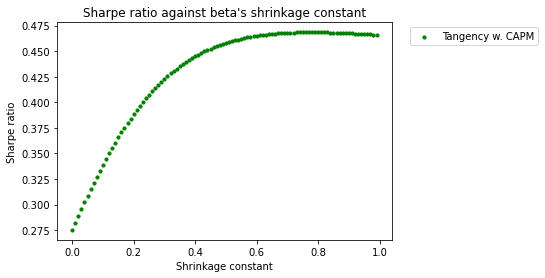

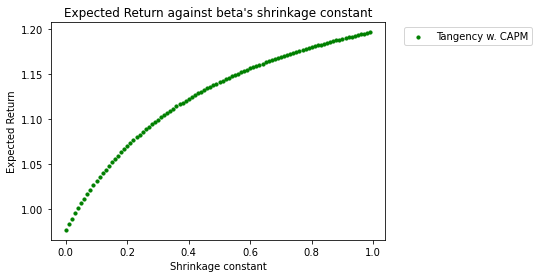

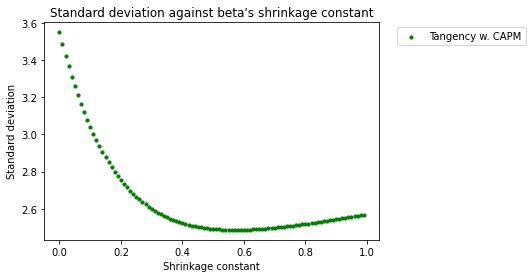

In [94]:
d_Bs = np.arange(0, 1, 0.01)

ers_B_tan = []
stds_B_tan = []
sharpes_B_tan = []

for d_B in d_Bs:
    dic = get_metrics("Tangency", "D", "C", V_shrinkages['Tangency']['D'], 1, n_points, data, beta_shrink = d_B)
    ers_B_tan.append(dic['Er'])
    stds_B_tan.append(dic['sigma'])
    sharpes_B_tan.append(dic['Sharpe'])

size = 10

custom_plot(d_Bs, sharpes_B_tan, "Tangency w. CAPM", "green", False, 0, 
            "Sharpe ratio against beta's shrinkage constant", "Shrinkage constant", 
            "Sharpe ratio", scatter_size = size, legend_outside = True)
plt.show()

custom_plot(d_Bs, ers_B_tan, "Tangency w. CAPM", "green", False, 0, 
            "Expected Return against beta's shrinkage constant", "Shrinkage constant", 
            "Expected Return", scatter_size = size, legend_outside = True)
plt.show()

custom_plot(d_Bs, stds_B_tan, "Tangency w. CAPM", "green", False, 0, 
            "Standard deviation against beta's shrinkage constant", "Shrinkage constant", 
            "Standard deviation", scatter_size = size, legend_outside = True)
plt.show()

In [95]:
m = min(stds_B_tan)
i = stds_B_tan.index(m)
best_beta = d_Bs[i]

## Sharpe Ratio, Return, and Standard Deviation against shrinkage constant for different structural assumptions on expected returns

In [96]:
d_Es = np.arange(0, 1, 0.01)

ers_E_tan = []
stds_E_tan = []
sharpes_E_tan = []

tan_V_mode = "D"
tan_d_V = V_shrinkages['Tangency']["D"]

for d_E in d_Es:
    dic = get_metrics("Tangency", tan_V_mode, "E", tan_d_V, d_E, n_points, data, beta_shrink = best_beta)
    ers_E_tan.append(dic['Er'])
    stds_E_tan.append(dic['sigma'])
    sharpes_E_tan.append(dic['Sharpe'])

ers_S_tan = []
stds_S_tan = []
sharpes_S_tan = []

for d_E in d_Es:
    dic = get_metrics("Tangency", tan_V_mode, "S", tan_d_V, d_E, n_points, data, beta_shrink = best_beta)
    ers_S_tan.append(dic['Er'])
    stds_S_tan.append(dic['sigma'])
    sharpes_S_tan.append(dic['Sharpe'])

ers_CAPM_tan = []
stds_CAPM_tan = []
sharpes_CAPM_tan = []

for d_E in d_Es:
    dic = get_metrics("Tangency", tan_V_mode, "C", tan_d_V, d_E, n_points, data, beta_shrink = best_beta)
    ers_CAPM_tan.append(dic['Er'])
    stds_CAPM_tan.append(dic['sigma'])
    sharpes_CAPM_tan.append(dic['Sharpe'])

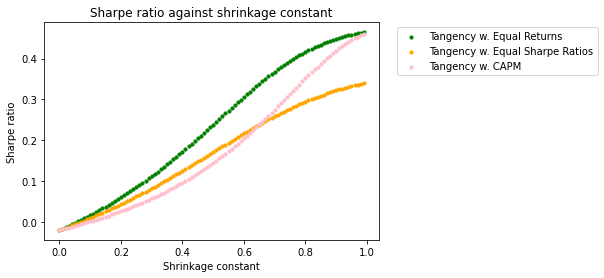

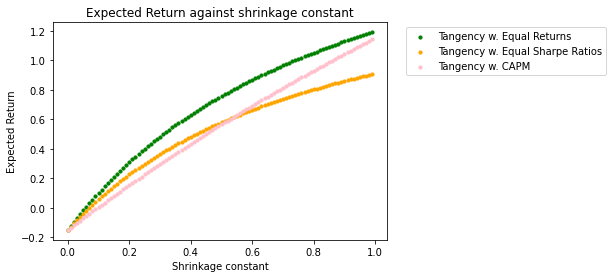

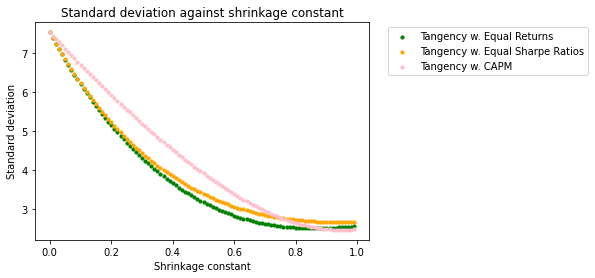

In [97]:
size = 10

custom_plot(d_Es, sharpes_E_tan, "Tangency w. Equal Returns", "green", False, 0, 
                          "Sharpe ratio against shrinkage constant", "Shrinkage constant", 
                          "Sharpe ratio", scatter_size = size)
custom_plot(d_Es, sharpes_S_tan, "Tangency w. Equal Sharpe Ratios", "orange", scatter_size = size)
custom_plot(d_Es, sharpes_CAPM_tan, "Tangency w. CAPM", "pink", 
            legend_outside = True, scatter_size = size)
plt.show()

custom_plot(d_Es, ers_E_tan, "Tangency w. Equal Returns", "green", False, 0, 
                          "Expected Return against shrinkage constant", "Shrinkage constant", 
                          "Expected Return", scatter_size = size)
custom_plot(d_Es, ers_S_tan, "Tangency w. Equal Sharpe Ratios", "orange", scatter_size = size)
custom_plot(d_Es, ers_CAPM_tan, "Tangency w. CAPM", "pink", 
            legend_outside = True, scatter_size = size)
plt.show()

custom_plot(d_Es, stds_E_tan, "Tangency w. Equal Returns", "green", False, 0, 
                          "Standard deviation against shrinkage constant", "Shrinkage constant", 
                          "Standard deviation", scatter_size = size)
custom_plot(d_Es, stds_S_tan, "Tangency w. Equal Sharpe Ratios", "orange", scatter_size = size)
custom_plot(d_Es, stds_CAPM_tan, "Tangency w. CAPM", "pink", 
            legend_outside = True, scatter_size = size)
plt.show()

In [98]:
models = [
    ("Tangency w. Equal returns", ers_E_tan, stds_E_tan, sharpes_E_tan),
    ("Tangency w. Equal Sharpes", ers_S_tan, stds_S_tan, sharpes_S_tan),
    ("Tangency w. CAPM", ers_CAPM_tan, stds_CAPM_tan, sharpes_CAPM_tan)
]

E_shrinkages = {}

dic = {}

for model in models:
    stds = model[2]
    m = min(stds)
    i = stds.index(m)
    dic[model[0]] = [model[1][i], model[2][i], model[3][i]]
    if model[0] == "Tangency w. Equal returns":
        E_shrinkages['E'] = d_Es[i]
    elif model[0] == "Tangency w. Equal Sharpes":
        E_shrinkages['S'] = d_Es[i]
    else:
        E_shrinkages['C'] = d_Es[i]

summarised_table_er = pd.DataFrame(dic)
summarised_table_er.index = ["Expected Return", "Standard Deviation", "Sharpe Ratio"]
summarised_table_er

,Tangency w. Equal returns,Tangency w. Equal Sharpes,Tangency w. CAPM
Expected Return,1.098623,0.886189,1.098135
Standard Deviation,2.510298,2.664325,2.467376
Sharpe Ratio,0.437647,0.332613,0.445062


## No shorting constraint

In [99]:
ports = ["GMV", "Tangency"]
V_modes = ["I", "D", "C"]
E_modes = ["E", "S", "C"]

no_shorts = {}
shorts = {}

V_names = {
    "I": "Identity",
    "D": "Diagonal",
    "C": "Constant"
}

E_names = {
    "E": "Equal returns",
    "S": "Equal Sharpe",
    "C": "CAPM"
}

dic = {}

for port in ports:
    for V_mode in V_modes:
        if port == "GMV":
            d_V = V_shrinkages[port][V_mode]
            temp = get_metrics(port, V_mode, "E", d_V, 1, n_points, data, beta_shrink = best_beta, no_short = True)
            
            dic[f"{port}, V: {V_names[V_mode]}"] = [temp["Er"], temp['sigma'], temp['Sharpe']]
            
        else:
            for E_mode in E_modes:
                d_V = V_shrinkages[port][V_mode]
                d_E = E_shrinkages[E_mode]
                
                temp = get_metrics(port, V_mode, E_mode, d_V, d_E, n_points, 
                                   data, beta_shrink = best_beta, no_short = True)
                dic[f"{port}, V: {V_names[V_mode]}, E: {E_names[E_mode]}"] = [temp["Er"], temp['sigma'], temp['Sharpe']]

summarised_table_no_short = pd.DataFrame(dic)
summarised_table_no_short.index = ["Expected Return", "Standard Deviation", "Sharpe Ratio"]
summarised_table_no_short

,"GMV, V: Identity","GMV, V: Diagonal","GMV, V: Constant","Tangency, V: Identity, E: Equal returns","Tangency, V: Identity, E: Equal Sharpe","Tangency, V: Identity, E: CAPM","Tangency, V: Diagonal, E: Equal returns","Tangency, V: Diagonal, E: Equal Sharpe","Tangency, V: Diagonal, E: CAPM","Tangency, V: Constant, E: Equal returns","Tangency, V: Constant, E: Equal Sharpe","Tangency, V: Constant, E: CAPM"
Expected Return,1.113752,1.120987,1.138533,1.627500,-1.662667,1.702333,1.627500,-1.662667,1.702333,1.408777,-1.662667,1.115025
Standard Deviation,2.669651,2.637509,2.655496,4.611338,10.376357,3.595610,4.611338,10.376357,3.595610,3.417581,10.376357,3.579672
Sharpe Ratio,0.417190,0.425017,0.428746,0.352934,-0.160236,0.473448,0.352934,-0.160236,0.473448,0.412215,-0.160236,0.311488


## Summary

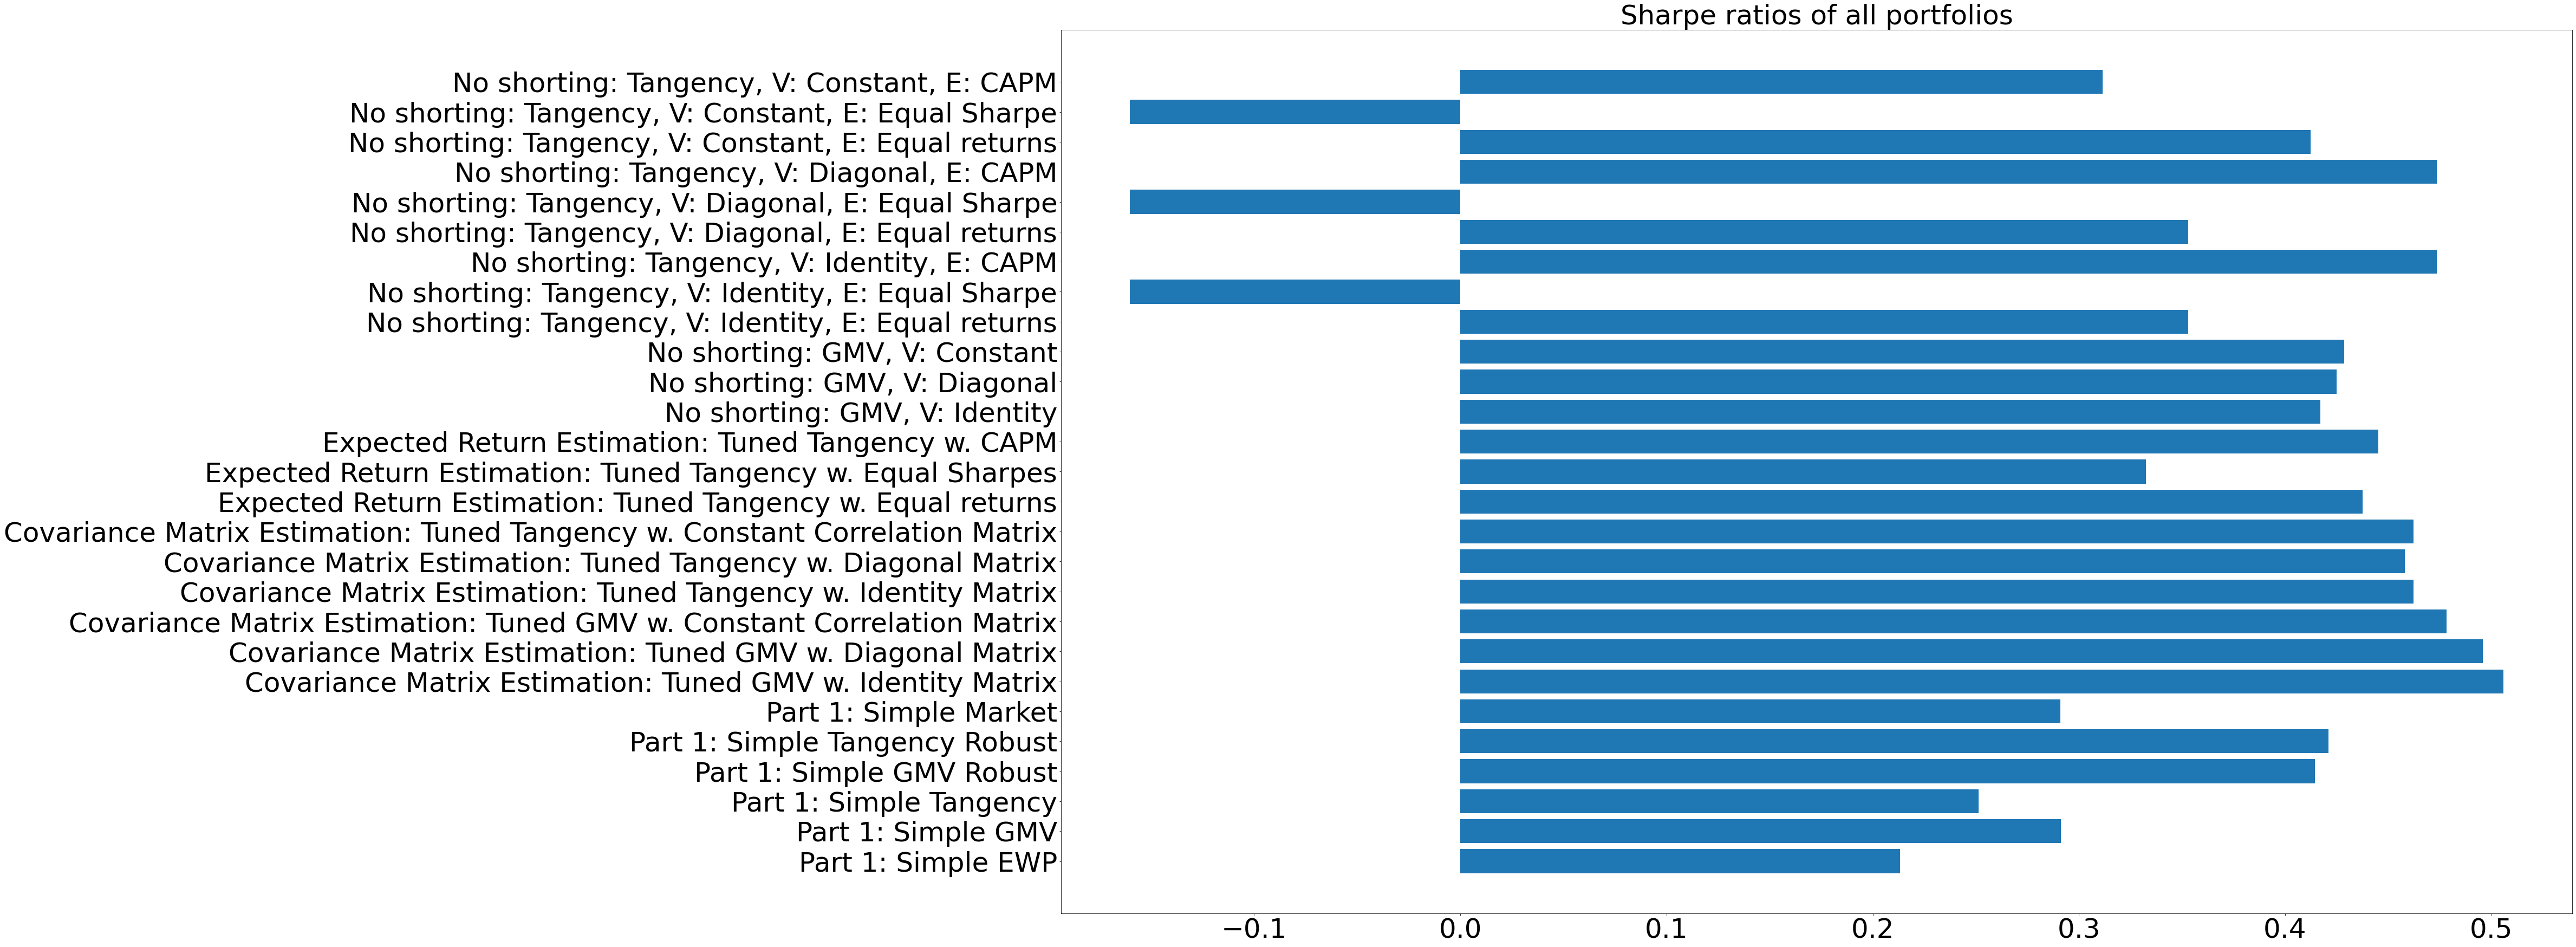

In [105]:
labels = []
heights = []
stds_final = []
ers_final = []

for col in summarised_table.columns:
    metrics = summarised_table[col]
    label = f"Part 1: Simple {col}"
    labels.append(label)
    heights.append(metrics["Sharpe ratio"])
    stds_final.append(metrics["Standard Deviation"])
    ers_final.append(metrics['Expected Return'])

for col in summarised_table_cov_mat.columns:
    metrics = summarised_table_cov_mat[col]
    label = f"Covariance Matrix Estimation: Tuned {col}"
    labels.append(label)
    heights.append(metrics["Sharpe Ratio"])
    stds_final.append(metrics["Standard Deviation"])
    ers_final.append(metrics['Expected Return'])
    
for col in summarised_table_er.columns:
    metrics = summarised_table_er[col]
    label = f"Expected Return Estimation: Tuned {col}"
    labels.append(label)
    heights.append(metrics["Sharpe Ratio"])
    stds_final.append(metrics["Standard Deviation"])
    ers_final.append(metrics['Expected Return'])
    
for col in summarised_table_no_short.columns:
    metrics = summarised_table_no_short[col]
    label = f"No shorting: {col}"
    labels.append(label)
    heights.append(metrics["Sharpe Ratio"])
    stds_final.append(metrics["Standard Deviation"])
    ers_final.append(metrics['Expected Return'])

plt.figure(figsize=(50,30))
plt.title("Sharpe ratios of all portfolios", fontsize=50)
plt.barh(labels, heights)
plt.yticks(fontsize=50)
plt.xticks(fontsize=50)

plt.show()

In [108]:
dic = {
    "Expected Return": ers_final,
    "Standard Deviation": stds_final,
    "Sharpe Ratio": heights
}

finalised = pd.DataFrame(dic)
finalised.index = labels
finalised

,Expected Return,Standard Deviation,Sharpe Ratio
Part 1: Simple EWP,0.822671,3.858277,0.213222
Part 1: Simple GMV,0.863082,2.963800,0.291208
Part 1: Simple Tangency,1.055857,4.201550,0.251302
Part 1: Simple GMV Robust,1.122783,2.708489,0.414542
Part 1: Simple Tangency Robust,1.141517,2.712153,0.420890
Part 1: Simple Market,1.010833,3.473068,0.291049
Covariance Matrix Estimation: Tuned GMV w. Identity Matrix,1.259603,2.489615,0.505943
Covariance Matrix Estimation: Tuned GMV w. Diagonal Matrix,1.225680,2.471401,0.495945
Covariance Matrix Estimation: Tuned GMV w. Constant Correlation Matrix,1.280742,2.678393,0.478176
Covariance Matrix Estimation: Tuned Tangency w. Identity Matrix,1.160242,2.509630,0.462316


## Final recommendation: GMV with tuned shrinkage estimator (Identity matrix)

In [113]:
# V_dic was used above to increase computation speed, but everything stored there assumes that training data is before 2011
# Thus, we need to reinitialise it so that we don't get the old cached covariance matrices
V_dic = {
    "I": np.identity(43),
    "C": {},
    "D": {},
    "F": {}
}

w = get_weights("GMV", "I", "C", V_shrinkages["GMV"]["I"], 1, n_points, data, 201601)
w

array([ 0.04898899,  0.1259614 ,  0.04968953,  0.08767367,  0.00359237,
        0.0084413 , -0.08347591,  0.00941781,  0.09293651,  0.04503157,
        0.07681686,  0.06477104,  0.071028  ,  0.0011516 , -0.01643011,
       -0.05974249, -0.01470823, -0.0296616 , -0.07685128,  0.02247653,
       -0.03347079, -0.01516133, -0.03370364,  0.00521007, -0.05363443,
        0.07507713,  0.06178109, -0.03554517, -0.00527716,  0.08133908,
        0.10877446,  0.03751592,  0.02840878,  0.03704924,  0.01908054,
       -0.02325337, -0.00515426,  0.04308696, -0.00199605,  0.07892396,
        0.03676749,  0.094317  ,  0.07275694])

In [114]:
submit = pd.DataFrame(w)
submit.columns = ["G2"]
submit.to_csv("Recommendation_G2.csv", index=False)